# Machine Learning Pipelines

## Why? – Some of the common problems

 - Different machine learning projects look different from one another
 - No clear structure around project creation
 - Lots of boilerplate in every project: file access, connections to S3, MLflow...
 - Lots of boilerplate in every project: file access, connections to S3, MLflow...
 - No single source of truth for artifacts: S3, GitHub repo, MLflow...
 - A single SUPER POWERFUL (and complex) function does everything
 - No automated testing whatsoever – A single function just makes things worse!
 

### Our problems, in code

```python
def train_model():
    # Get data
    d = datasets.load_iris()
    raw_data = pd.DataFrame(d["data"])
    raw_data.columns = d["feature_names"]
    raw_data["target"] = d["target"]
    
    # Add feature interactions
    ft = raw_data["sepal length (cm)"] * raw_data["sepal width (cm)"]
    engineered_features = pd.DataFrame({"sepal area (cm2)": ft})
    
    # Merge features into a single data frame
    training_data = raw_data.join(engineered_features)
    
    # Split data
    x = training_data.drop("target", axis="columns")
    y = training_data[["target"]]
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)
    
    # Model training
    clf = RandomForestClassifier()
    clf.fit(train_x, train_y["target"])
    mlflow.log_params(clf.get_params())
    y_pred = clf.predict(train_x)
    training_accuracy = accuracy_score(train_y, y_pred)
    mlflow.log_metric('training_accuracy', training_accuracy)
    
    # Model testing
    y_pred = model.predict(test_x)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca()
    ConfusionMatrixDisplay.from_estimator(model, test_x, test_y, ax=ax)
    testing_accuracy = accuracy_score(test_y, y_pred)
    mlflow.log_metric('testing_accuracy', testing_accuracy)
    
if __name__ == '__main__':
    train_model()
```

## Solution: pipelines!

Adopting a standardised set of steps allows for more structured, testable and automatable data science projects. With this in mind, we decided to create a framework named *Code-First Pipelines* that sits on top of *[Ploomber](https://ploomber.io/)* to support creation, maintenance and deployment of machine learning models. 

Following a single principle:

 > Effective machine learning pipelines **hide the details of the pipeline implementation and allow data science practitioners to focus on their business-specific, data science problem**. Machine learning is continuous. The more we automate the process, the more we are free to solve additional business problems. – [Data Science on AWS](https://www.oreilly.com/library/view/data-science-on/9781492079385/)
 
The goals of *Code-First Pipelines* are:

 - Make it easy to navigate across all our projects by having the same structure
 - Reduce friction between scientists and engineers, remember: we follow a code structure 
 - Handle all the red-tape (connections, error handling, artifact management...) away from the data scientist
 - Encourage the creation of small, testable functions
 - Version artifacts automatically

## A pipeline

We understand a generalised machine learning pipeline as being comprised of several conceptual steps:

Where each step can be further decomposed into several functions for the purposes of code modularity and testing.

## Classifying flowers – classic

In [1]:
# Standard imports for the example

import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# !rm -rf outputs mlruns

### Pipeline

We need to import the class `MLPipeline` from the `cf_pipelines.ml` module:

In [3]:
from cf_pipelines.ml import MLPipeline

A pipeline has a name – ideally the name of the project and a location. If you don't provide one, a temporary one will be selected fot you.

In [4]:
iris_pipeline = MLPipeline("Iris pipeline", location='outputs')

## Steps

### First step – data ingestion

As mentioned early, a pipeline is comprised of conceptual steps, and each step can have many functions – it can be just one, though. 

To include a function as part of the pipeline you must use the corresponding decorator to the function. For example, I have selected *"data_ingestion"* since I am geting that task:

In [5]:
@iris_pipeline.data_ingestion
def get_data():
    d = datasets.load_iris()
    df = pd.DataFrame(d["data"])
    df.columns = d["feature_names"]
    df["target"] = d["target"]
    return {"raw_data.csv": df}

A step function can contain any Python code, but an important requisite is that it has to return a dictionary with at least one key-value pair:

 - The **key** can be any valid Python identifier (a combination of letters in lowercase or uppercase, digits and underscores), like "raw_data" followed by a file extension, like ".csv"
 - The **value** that should be associated with the key
 
These key value pairs are what we will know as a **product**.

The products a function returns will be available for each subsequent step within the pipeline.

#### Why do we need a file extension?

The extension will determine how the product is persisted on disk. Yes! the pipelines store a copy of each product ensuring there is full reproducibility and data provenance. And at the same time, a copy is persisted for tracking purposes to MLflow – all for free.

### A second step – feature engineering

Say I have a step that depends on a product generated by a previous step. In order for me to access it I would need to add it as a named argument for the function that needs it. For example, in the function below I want to use a dataframe from the previous step, I specify `raw_data` as a named argument, and then treat its value as I would do with any other dataframe. 

 > 🚨 Named arguments should appear after a single asterisk `*` in the function arguments)

In [6]:
@iris_pipeline.feature_engineering
def create_feature_interactions(*, raw_data):
    ft = raw_data["sepal length (cm)"] * raw_data["sepal width (cm)"]
    df = pd.DataFrame({"sepal area (cm2)": ft})
    return {"engineered_features.parquet": df}

¿See?, I am returning yet another product with a different file extension and it will be stored and available for me to consume in the next steps.

### More steps – more feature engineering

In the next steps I want to demonstrate a two things:

 - A step function can consume the products generated by any other previous functions, not necessarily only the previous one, in the function below I am using both `raw_data` and `engineered_features`
 - A step function can generate more than one product

In [7]:
@iris_pipeline.feature_engineering
def join_features(*, raw_data, engineered_features):
    training_data = raw_data.join(engineered_features)
    return {"training_data.csv":training_data}
    

@iris_pipeline.feature_engineering    
def create_splits(*, training_data):

    x = training_data.drop("target", axis="columns")
    y = training_data[["target"]]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

    return {
        "train_x.csv": x_train,
        "test_x.csv": x_test,
        "train_y.csv": y_train,
        "test_y.csv": y_test,
    }

## Training and testing a model

But what if we want to save some parameters to MLflow, to keep track of our experiment runs?

The `MLPipeline` offers a way for you to interact directly with *MLflow*. To use it it is enough to add `mlflow` as an argument to the function:

In [8]:
@iris_pipeline.model_training
def model_training(*, train_x, train_y, mlflow):
    clf = RandomForestClassifier()
    clf.fit(train_x, train_y["target"])

    mlflow.log_params(clf.get_params())

    y_pred = clf.predict(train_x)
    training_accuracy = accuracy_score(train_y, y_pred)

    mlflow.log_metric('training_accuracy', training_accuracy)

    return {"model": clf}

As you can see, the above product does not specify an extension, which means the product will be persisted using the pickle module. This may bot be the best way to store something on disk, so my recommendation is that you always try to specify an extension.

In [9]:
@iris_pipeline.model_testing
def test_my_model(*, test_x, test_y, model, mlflow):
    y_pred = model.predict(test_x)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.gca()
    ConfusionMatrixDisplay.from_estimator(model, test_x, test_y, ax=ax)
    testing_accuracy = accuracy_score(test_y, y_pred)
    mlflow.log_metric('testing_accuracy', testing_accuracy)
    return {"matrix.png": fig}

## Look at what you just made

You will need to install GraphViz

In [10]:
iris_pipeline.draw(size="10,4")

ImportError: You need to install pygraphviz

## Run the pipeline

Finally, we can execute the pipeline by using its `run` method.

2022/09/08 09:42:13 INFO mlflow.tracking.fluent: Experiment with name 'Iris pipeline' does not exist. Creating a new experiment.


  0%|          | 0/6 [00:00<?, ?it/s]

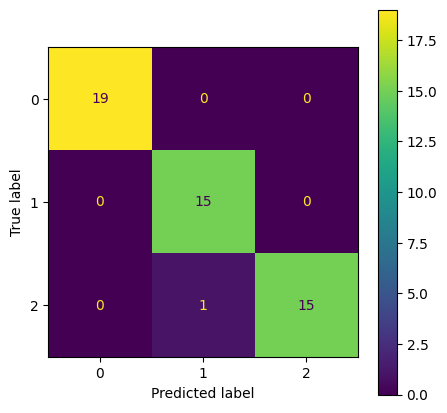

In [11]:
iris_pipeline.run()

## What else do you get for *FREE*?

 - All artifacts are uploaded to MLflow automatically
   - Everything is versioned
   - There is a uniform structure
 - Functions can be tested and executed individually
 - Complete focus on your data science code
   - No dealing with reading/writing data to disk

## Reviewing the outputs

In [ ]:
!tree outputs

In [ ]:
!head outputs/default/feature_engineering/test_x.csv

### Making predictions with the trained model

In [ ]:
import pickle

with open("outputs/default/model_training/model", "rb") as rb:
    classifier = pickle.load(rb)

In [ ]:
new_instance = {
    "sepal length (cm)": 6.0,
    "sepal width (cm)": 3.1,
    "petal length (cm)": 3.8,
    "petal width (cm)": 0.5,
    "sepal area (cm2)": 18.6,
}
instance = pd.DataFrame([new_instance])

In [ ]:
classifier.predict(instance)

## Testing the functions individually  

In [ ]:
input_data = pd.DataFrame({'sepal length (cm)': [1, 2], 'sepal width (cm)': [3, 4]})
input_data.head()

In [ ]:
expected = pd.DataFrame({'sepal area (cm2)':[3, 8]})
expected.head()

In [ ]:
results = create_feature_interactions(raw_data=input_data)
engineered_features = results['engineered_features']
engineered_features.head()

In [ ]:
pd.testing.assert_frame_equal(expected, engineered_features)

## What else do you get for *FREE*?

 - All artifacts are uploaded to MLflow automatically
   - Everything is versioned
   - There is a uniform structure
 - Functions can be tested and executed individually
 - Complete focus on your data science code
   - No dealing with reading/writing data to disk

## What is next?

 - Make it available in the SBML image on SageMaker Studio
 - Automate a project template creation
 - Include error handling
 - Include metric reporting to NewRelic
 - Get your feedback!
 